## Catalog box API

**Author**: Sandro Campos

This notebook demonstrates the new box API on LSDB catalogs to filter pixels by:

- __(1)__ Right ascension band: `catalog.box(ra=(theta_1,theta_2))`

- __(2)__ Declination band: `catalog.box(dec=(phi_min,phi_max))`

- __(3)__ Both right ascension and declination: `catalog.box(ra=(theta_1,theta_2),dec=(phi_min,phi_max))`

The current implementation consists of two stages:

- __(Coarse and lazy)__: filtering the catalog HEALpix to obtain those that overlap with the region

- __(Fine)__: filtering the points inside each HEALPix to get those that are inside of the region

In [1]:
import lsdb
import hipscat as hc

### Helper methods to plot filters and catalog pixel maps

In [2]:
import healpy as hp
import numpy as np
from hipscat.inspection import plot_pixels
from hipscat.pixel_math import HealpixPixel

def plot_catalog_pixel_map(hc_catalog):
    order = hc_catalog.pixel_tree.get_max_depth()
    order_map = construct_pixel_map(hc_catalog.get_healpix_pixels(), order)
    plot_pixel_map(order_map, f"{hc_catalog.catalog_info.catalog_name} pixel map")
    
def plot_ra_filter(ra_range, order):
    pixel_tree = hc.pixel_math.box_filter._generate_ra_strip_pixel_tree(ra_range, order)
    pixels_in_range = [HealpixPixel(order, p) for p in pixel_tree.pixels[order]]
    order_map = construct_pixel_map(pixels_in_range, order)
    plot_pixel_map(order_map, f"Filter for ra {ra_range[0]} to {ra_range[1]}")
    
def plot_dec_filter(dec_range, order):
    pixel_tree = hc.pixel_math.box_filter._generate_dec_strip_pixel_tree(dec_range, order)
    pixels_in_range = [HealpixPixel(order, p) for p in pixel_tree.pixels[order]]
    order_map = construct_pixel_map(pixels_in_range, order)
    plot_pixel_map(order_map, f"Filter for dec {dec_range[0]} to {dec_range[1]}")
    
def plot_pixel_map(order_map, title=""):
    hp.newvisufunc.projview(
        order_map,
        projection_type="mollweide",
        graticule=True,
        graticule_labels=True,
        xtick_label_color="green",
        ytick_label_color="green",
        unit="pixel is in map",
        xlabel="ra",
        ylabel="dec",
        nest=True,
        title=title,
    )

def construct_pixel_map(pixels, max_order):
    order_map = np.full(hp.order2npix(max_order), 0)
    for pixel in pixels:
        explosion_factor = 4 ** (max_order - pixel.order)
        exploded_pixels = [
            *range(
                pixel.pixel * explosion_factor,
                (pixel.pixel + 1) * explosion_factor,
            )
        ]
        order_map[exploded_pixels] = 1
    return order_map

### Create Dask Client

In [3]:
from dask.distributed import Client

client = Client(n_workers=4)
client

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34319 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34319/status,
Dashboard: http://127.0.0.1:34319/status,Workers: 4
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40851,Workers: 4
Dashboard: http://127.0.0.1:34319/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:44058,Total threads: 24
Dashboard: http://127.0.0.1:34484/status,Memory: 251.90 GiB
Nanny: tcp://127.0.0.1:35475,


### Import a catalog

Let's import a catalog using `read_hipscat` and visualize its pixel distribution:

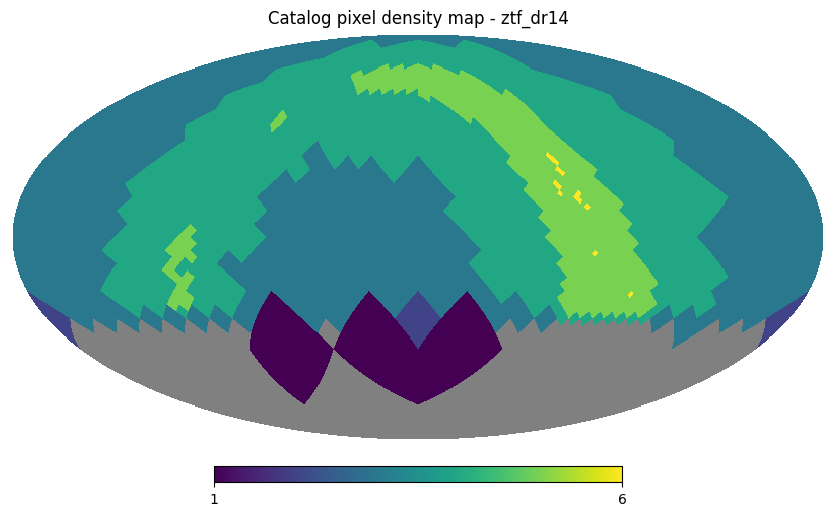

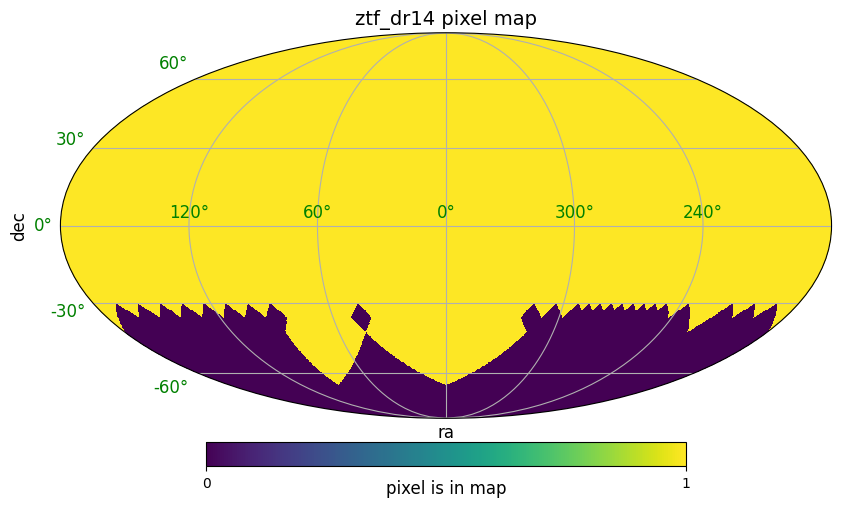

In [4]:
ztf_dr14 = lsdb.read_hipscat("epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

ztf_dr14_order = ztf_dr14.hc_structure.pixel_tree.get_max_depth()

plot_pixels(ztf_dr14.hc_structure)
plot_catalog_pixel_map(ztf_dr14.hc_structure)

### Search by right ascension

Search by points in the RA band. Let's also look at the filter created and the results obtained.

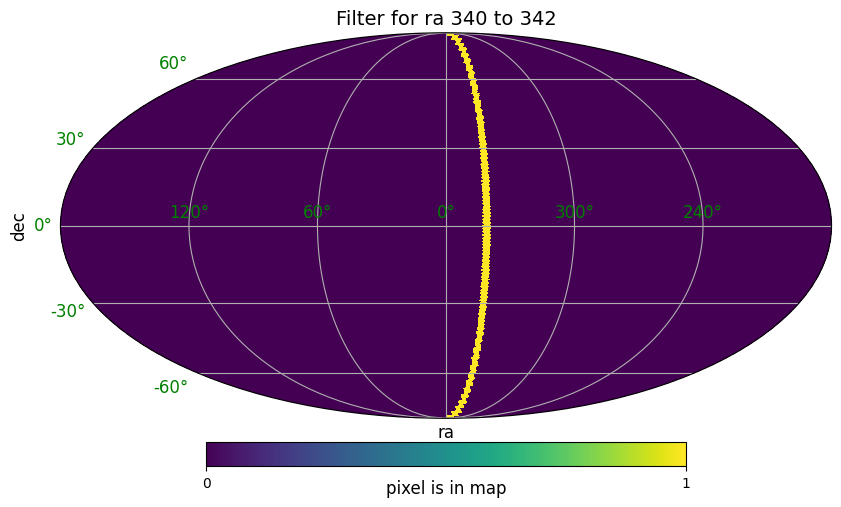

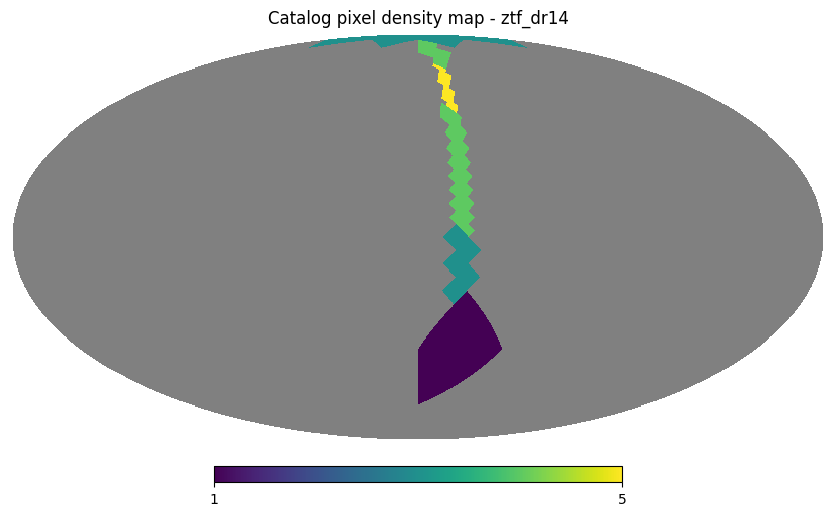

In [5]:
ra_search_catalog = ztf_dr14.box(ra=(340, 342))
plot_ra_filter((340, 342), ztf_dr14_order)
plot_pixels(ra_search_catalog.hc_structure)

In [6]:
ra_search_catalog._ddf.partitions[10].compute()

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
3805541713917771776,147373403140611231,340.314209,32.808701,-999.000000,-999.000000,20.156900,42,0,0,20.904580,NaN,NaN,4,0,845
3805541723606614016,147363403073049928,340.307434,32.807568,21.500299,-999.000000,20.785101,0,0,3,NaN,NaN,20.557503,4,0,845
3805541729738686464,147373403048930196,340.304962,32.808015,21.724199,20.908600,20.378901,15,352,25,21.752482,20.981214,20.364288,4,0,845
3805541773590134784,147383403279110322,340.327911,32.816481,-999.000000,21.728201,21.261600,0,49,9,NaN,21.448769,20.667615,4,0,845
3805541773896318976,147383403267550521,340.326591,32.816627,-999.000000,21.954399,21.209499,3,119,15,21.775067,21.332165,20.464438,4,0,845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810045243923890176,154403403165286316,340.316528,38.671413,-999.000000,21.787399,20.711300,0,15,0,NaN,21.221513,NaN,4,0,845
3810045250336980992,154413403179001421,340.317886,38.675665,21.779200,21.533300,21.305500,2,11,0,21.838520,21.264524,NaN,4,0,845
3810045268703838208,154403403139507524,340.313995,38.672333,22.303101,22.208500,21.652800,0,1,0,NaN,21.193581,NaN,4,0,845


### Search by declination

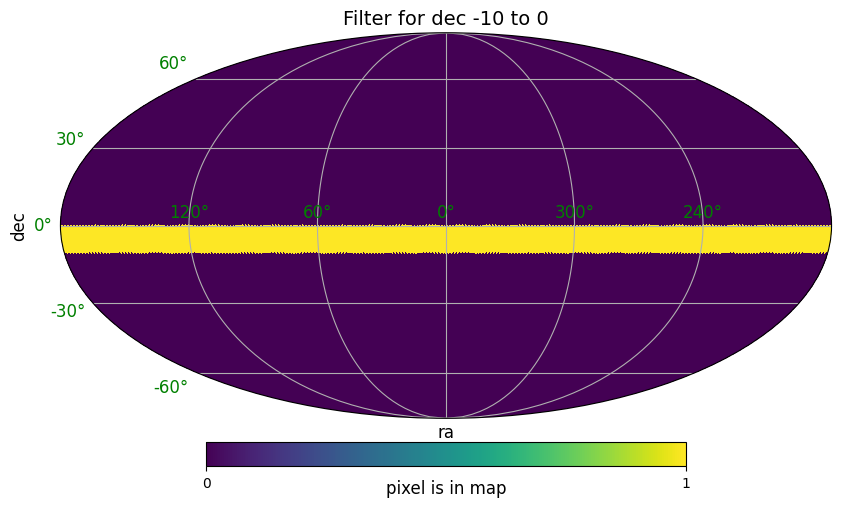

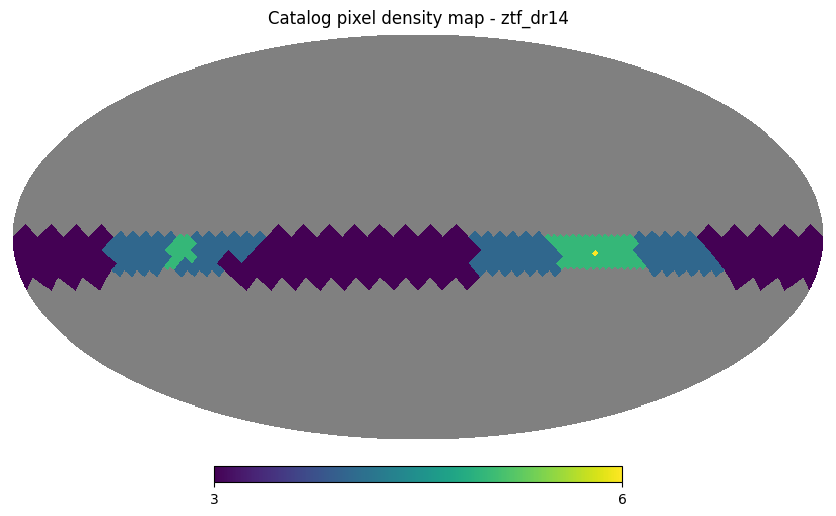

In [7]:
dec_search_catalog = ztf_dr14.box(dec=(-10, 0))
plot_dec_filter((-10, 0), ztf_dr14_order)
plot_pixels(dec_search_catalog.hc_structure)

In [8]:
dec_search_catalog._ddf.partitions[0].compute()

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
4755651102936924160,96000117069111494,11.706884,-9.999184,20.978500,21.155001,21.303801,118,60,1,20.877533,21.016140,20.864859,3,0,263
4755651468868976640,96000117018962990,11.701921,-9.997720,21.914700,21.537001,21.431601,15,21,0,21.383843,21.198537,NaN,3,0,263
4755651481074401280,96000117030767799,11.702986,-9.993927,15.410400,14.215000,13.560300,308,347,20,15.483231,14.057583,13.267700,3,0,263
4755651489291042816,96010117082210329,11.708456,-9.991751,21.932800,-999.000000,21.591200,2,2,0,21.720320,20.839679,NaN,3,0,263
4755651532643368960,96010117027249258,11.702682,-9.984302,20.741501,19.699600,18.491100,112,287,19,20.878790,19.490718,18.258398,3,0,263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4755801121019133952,96460112393326020,11.239320,-9.611870,22.132200,21.528601,21.459400,8,25,0,21.182746,21.230294,NaN,3,0,263
4755801128694710272,96470112409621554,11.240993,-9.607410,20.096800,18.875099,18.085199,207,319,0,20.155802,18.737634,NaN,3,0,263
4755801164161744896,96470112524674391,11.252469,-9.604885,-999.000000,-999.000000,21.427999,0,8,0,NaN,21.273111,NaN,3,0,263


### Search by box of right ascension and declination

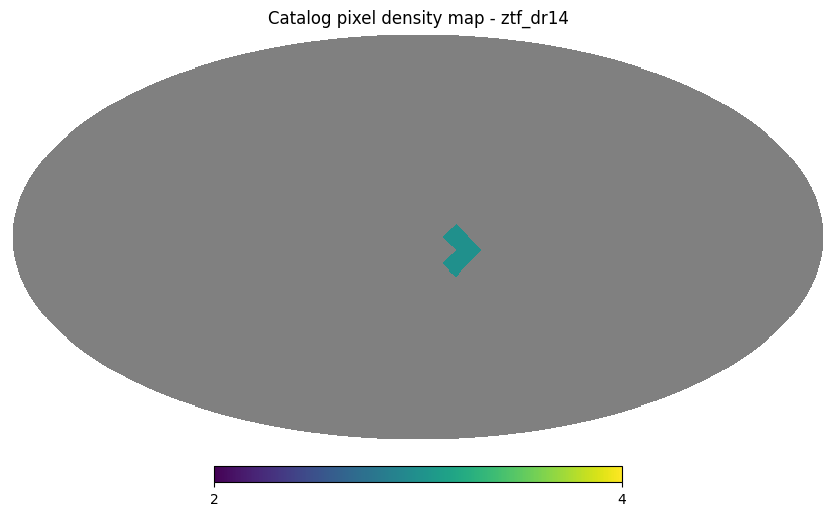

In [9]:
box_search_catalog = ztf_dr14.box(ra=(340, 342), dec=(-10, 0))
plot_pixels(box_search_catalog.hc_structure)

In [10]:
box_search_catalog._ddf.partitions[0].compute()

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
5216144441609289728,96003407228302933,340.722839,-9.997852,21.881201,-999.000000,21.558701,0,0,1,NaN,NaN,20.654509,3,0,289
5216144446948638720,96003407298384243,340.729712,-9.996815,14.199300,13.354000,12.994000,198,264,31,14.255615,13.201436,12.818056,3,0,289
5216144508994977792,96003407468342257,340.746765,-9.998428,-999.000000,21.961599,21.175100,0,4,6,NaN,21.104851,20.564282,3,0,289
5216144519531069440,96003407552736987,340.755361,-9.994563,22.271200,21.675501,21.173901,0,18,4,NaN,21.106589,20.669701,3,0,289
5216144574132518912,96013407542030525,340.754242,-9.991535,20.498899,19.957399,19.632999,68,154,25,20.701595,19.815037,19.495706,3,0,289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5223822232668602368,101093419992752711,341.999252,-5.756207,-999.000000,21.991699,22.155600,0,5,0,NaN,21.505956,NaN,3,0,289
5223822255477227520,101093419857593753,341.985802,-5.755494,21.471399,21.372601,21.560600,21,50,0,21.354521,21.050909,NaN,3,0,289
5223822255892463616,101093419845944049,341.984604,-5.755226,-999.000000,-999.000000,21.641399,0,4,0,NaN,21.378485,NaN,3,0,289


### Additional insights

There are lots of important edge cases covered by unit tests. Keep in mind that we are including all the pixels that overlap with the region, which means we may get pixels that partially fall outside of it.

- The ranges should not coincide (e.g. `[0,0]` or `[50,50]` should not be valid, for both RA and DEC)

- The declination range must be provided in ascending order

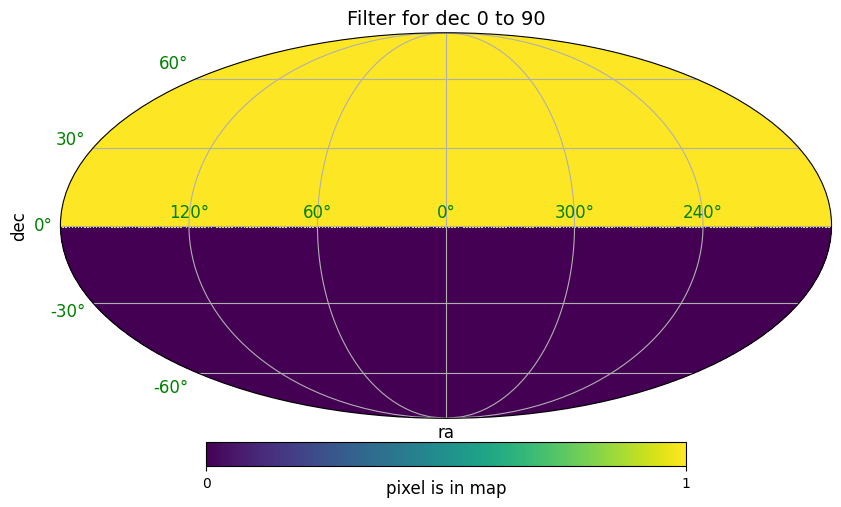

In [11]:
# To get the whole of the north hemisphere
plot_dec_filter((0, 90), ztf_dr14_order)

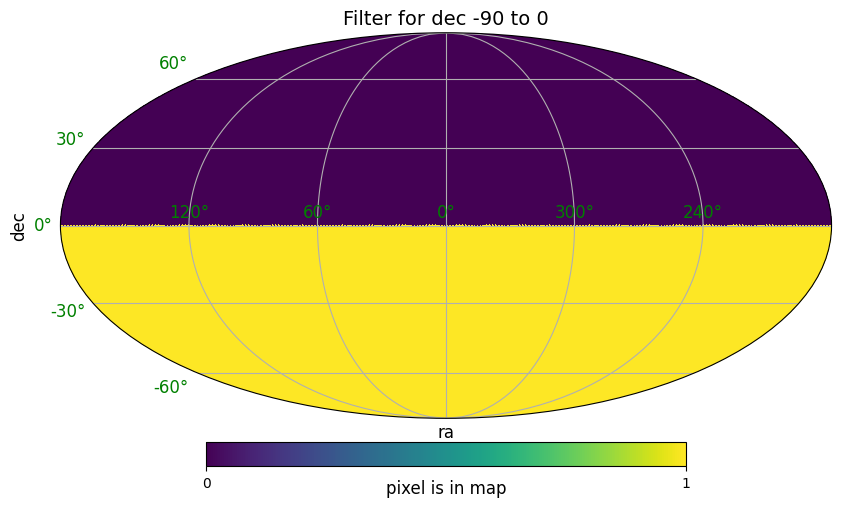

In [12]:
# To get the whole of the north and south hemisphere
plot_dec_filter((-90, 0), ztf_dr14_order)

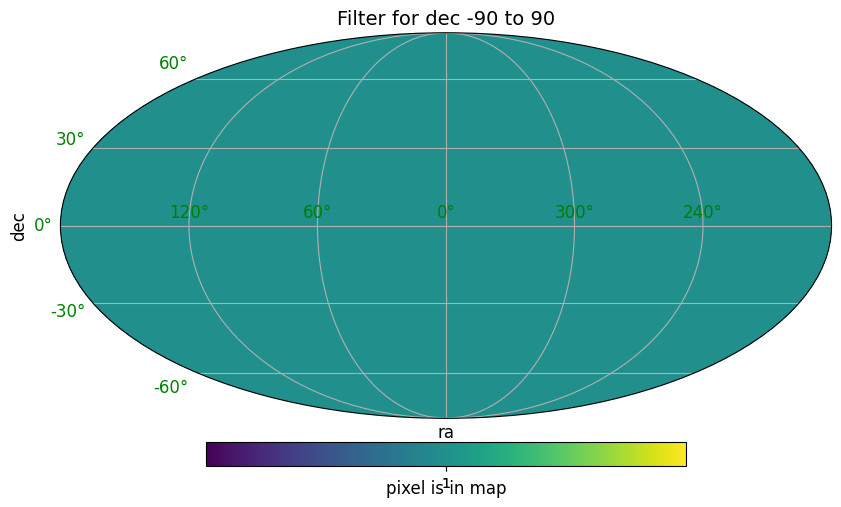

In [13]:
# To get the whole of the north and south hemisphere
plot_dec_filter((-90, 90), ztf_dr14_order)

- It's crucial to consider the angle order of the RA ranges because they yield "complementary" polygons

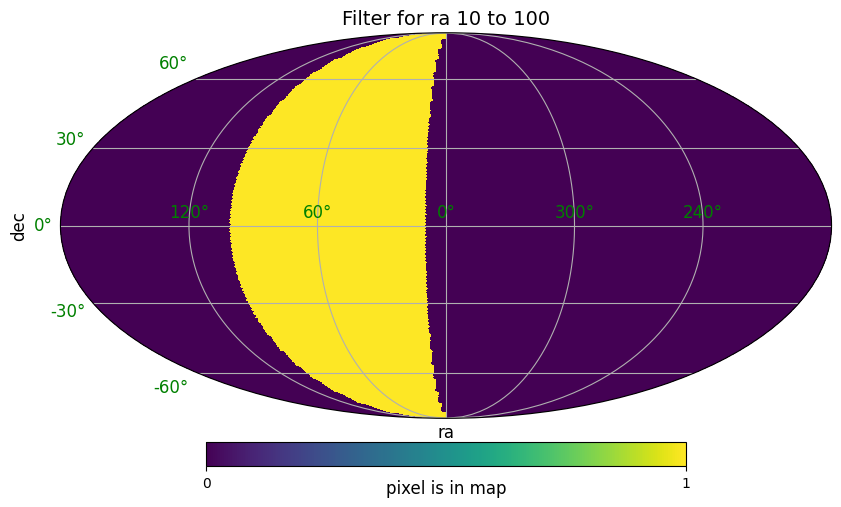

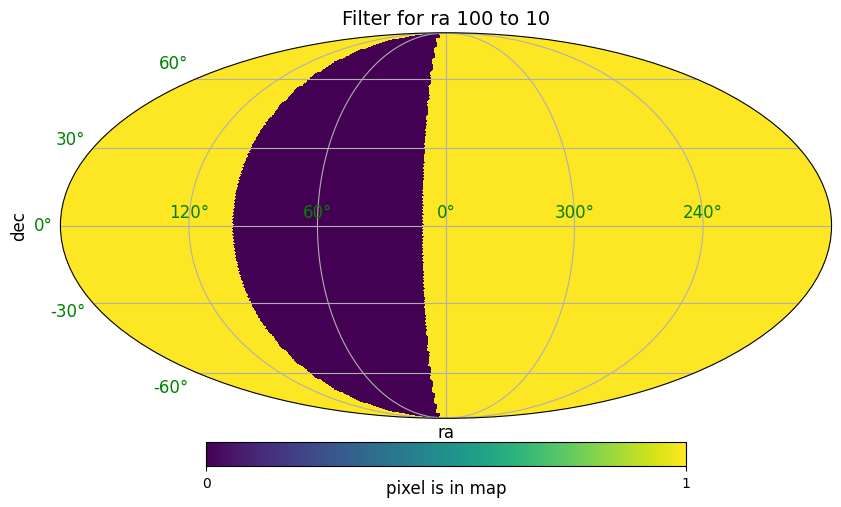

In [14]:
# While [10,50] yields a small polygon of 40 degrees, [50,10] should yield a polygon of 320 degrees
plot_ra_filter((10, 100), ztf_dr14_order)
plot_ra_filter((100, 10), ztf_dr14_order)

In fact, whenever right ascensions are >= 180 we should consider the wider polygon:

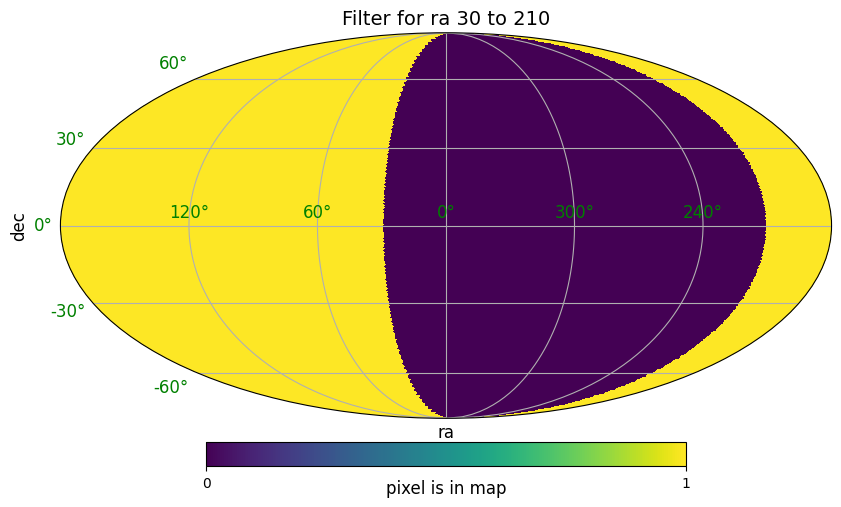

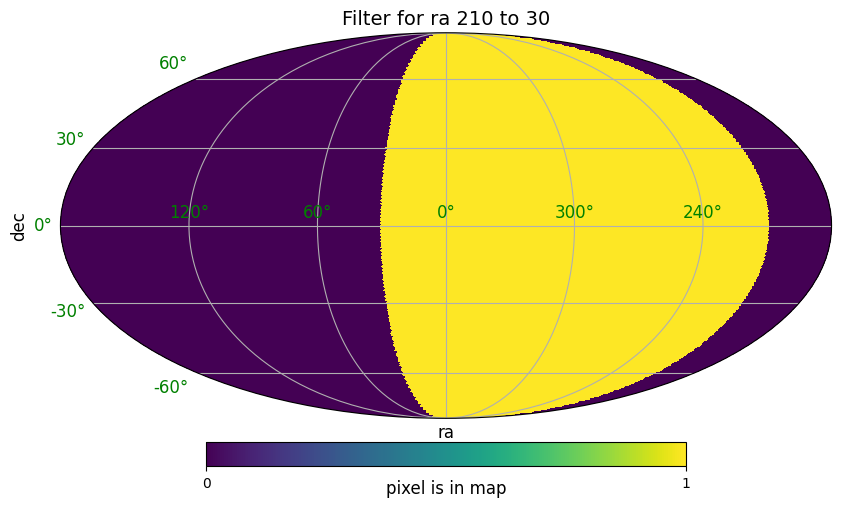

In [15]:
plot_ra_filter((30, 210), ztf_dr14_order)
plot_ra_filter((210, 30), ztf_dr14_order)

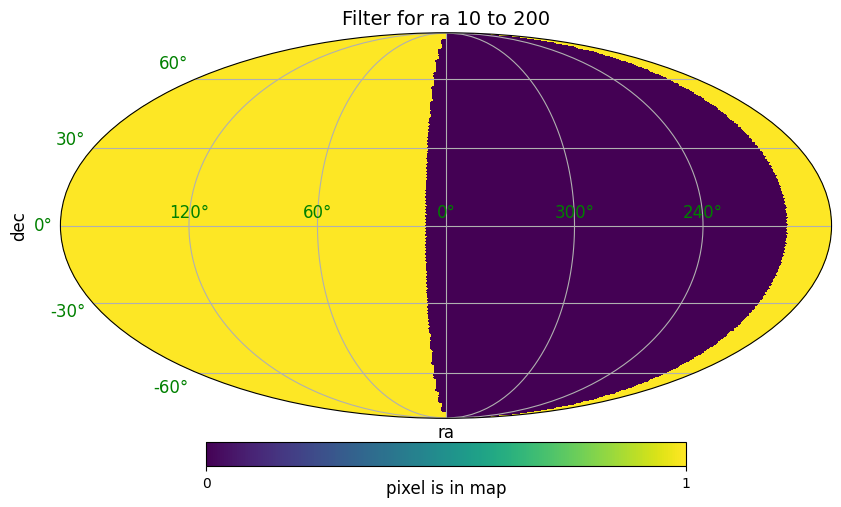

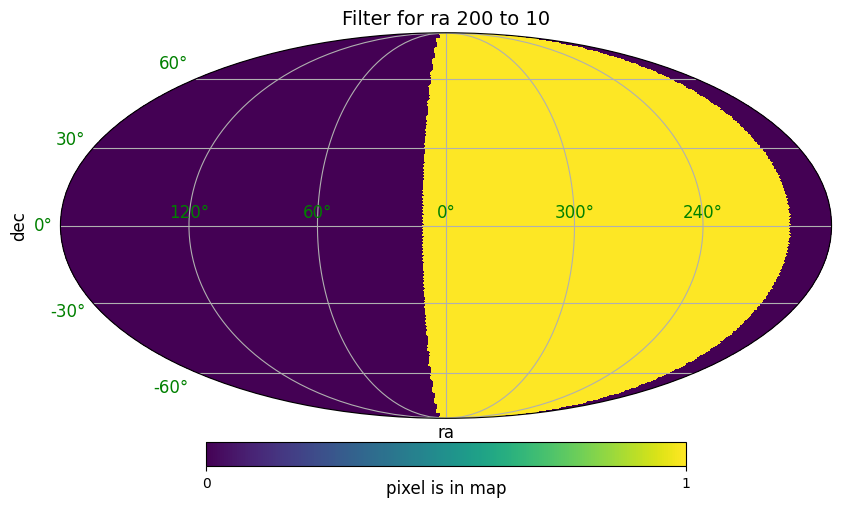

In [16]:
plot_ra_filter((10, 200), ztf_dr14_order)
plot_ra_filter((200, 10), ztf_dr14_order)

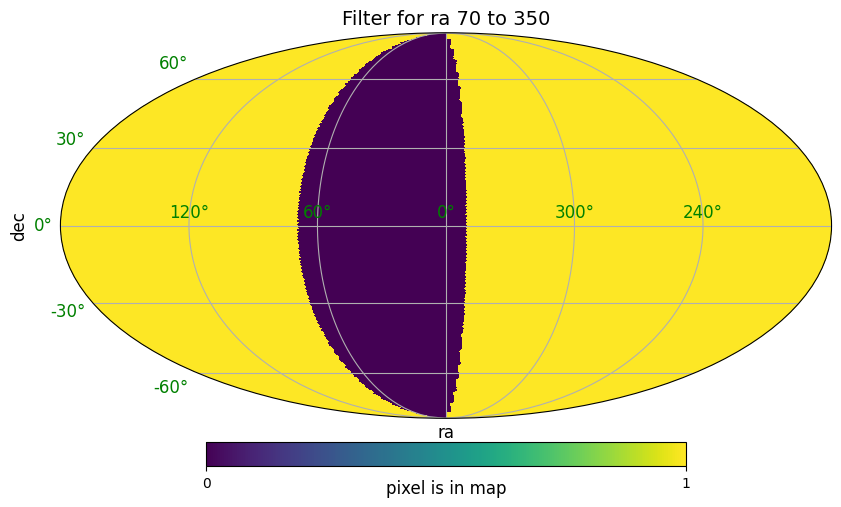

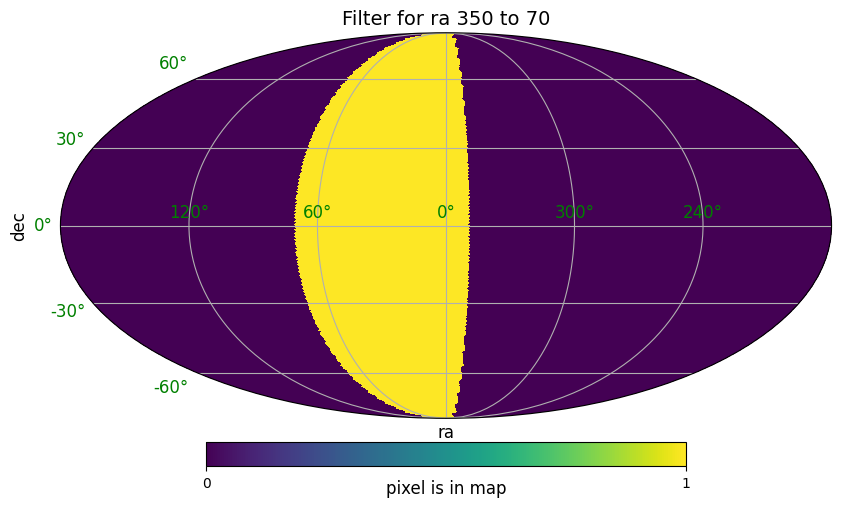

In [17]:
plot_ra_filter((70, 350), ztf_dr14_order)
plot_ra_filter((350, 70), ztf_dr14_order)

In [18]:
client.close()